# About
Single-step univariate Convolutional Neural Network (CNN)

# Univariate Time Series
Univariate time series are datasets comprised of a single series of observations with a temporal ordering and a model is required to learn from the series of past observations to predict the next value in the sequence.
-  The CNN model will learn a function that maps a sequence of past observations as input to an output observation

## Note:
* The chosen configuration of the models is arbitrary and not optimized for each problem; that was not the goal.

# Univariate Hybrid CNN-LSTM Model

# Global Parameters

In [1]:
name_prefix = "Uni-Hybrid-CNN-Bi-LSTM"

# Libraries

In [2]:
%run "/home/cesar/Python_NBs/HDL_Project/HDL_Project/global_fv.ipynb"

In [3]:
import os
import glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Data
from sklearn.model_selection import train_test_split

# DL Model
from tensorflow.keras import Sequential
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import LSTM, Flatten, Dense, TimeDistributed, Bidirectional

# Optimizer
from tensorflow.keras.optimizers import Adam

# Plotting
import matplotlib.pyplot as plt

# Early stopping
from tensorflow.keras.callbacks import EarlyStopping

# Checkpoint
from keras.callbacks import ModelCheckpoint

# User-Defined Functions

In [4]:
def design_model(n_steps, lr, n_features = 1):
    """
    n_steps: Number of steps
    n_features: Number of features
    lr: Learning rate
    """
    # We define a 1D CNN Model for univariate time series forecasting as follows:
    model = Sequential(name = "Univariate-Hybrid-CNN-Bi-LSTM")
    
    # Number of neurons (nodes) are just about greater than the number of features.
    # Rule of thumb is for number of neurons to be about 2/3 of the input    
    num_neurons = 64
    
    # CNN Layer
    model = Sequential()
    model.add(TimeDistributed(Conv1D(num_neurons, 1, activation= 'relu' ), input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(MaxPooling1D()))
    model.add(TimeDistributed(Flatten()))
    #model.add(LSTM(50, activation= 'relu' ))
    model.add(Bidirectional(LSTM(num_neurons, activation= 'relu' ), input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer= 'adam' , loss= 'mse' )
    
    # Regularization prevents the learning process to completely fit the model to the training data which can lead to overfitting.
    # The most common regularization method is dropout.
    #model.add(layers.Dropout(0.1))    
    
    # Optimizer
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt,  metrics=['mae'], loss= 'mse')
    
    return model

In [5]:
def fit_model_es_checkpoint(X, y, learning_rate, num_epochs, bs, model):
    checkpoint_name = 'Trained_Models/U_Weights_Uni-Hybrid-CNN-Bi-LSTM_-{val_loss:.5f}--{epoch:03d}.hdf5'
    
    early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=15)
    checkpoint_callback = ModelCheckpoint(checkpoint_name, monitor='mae', verbose=0, save_best_only=True, mode='min')
    history = model.fit(X, y, epochs=num_epochs, batch_size=bs, validation_split = 0.30, verbose = 0, shuffle = False, callbacks=[early_stopping_callback, checkpoint_callback])
    return history

# Data

##  Parameters

In [6]:
# SQL commands to retrieve data
sql_table = "sima_pm25"
column = "NE"
sql_where = "where datetime >= \'2020-04-17\'"

# Percentage of time series dedicated for test split
test_partition = 0.3

# Number of time steps per sample
n_steps = 24

## Data Preparation

## Sample preparation

In [7]:
uni_ts = univariate_samples(sql_table, column, sql_where)
X, y = uni_ts.samples_creation(n_steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_partition, shuffle= False)

In [8]:
print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))
print()
print(" shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print()
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X shape: (63912, 24)
y shape: (63912,)

 shape: (44738, 24)
y_train shape: (44738,)

X_test shape: (19174, 24)
y_test shape: (19174,)


### Reshaping for hybrid model

In [9]:
# Parameters

n_features = 1
n_seq = 4
n_steps = 6

In [10]:
X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps, n_features))
X_test  = X_test.reshape((X_test.shape[0], n_seq, n_steps, n_features))

print("X_train shape: {}".format(X_train.shape))
print()
print("X_test shape: {}".format(X_test.shape))

X_train shape: (44738, 4, 6, 1)

X_test shape: (19174, 4, 6, 1)


# Model Definition

## Parameters

In [11]:
lr = 0.01
# Maximum number of epochs
num_epochs = 100

#fixed number of batches
batch_size = 7

In [12]:
# Define the model
model = design_model(n_steps, lr)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 6, 64)      128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 3, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 192)        0         
 tributed)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 128)              131584    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 1

# Training the model

Elapsed time is 513.911674 seconds.


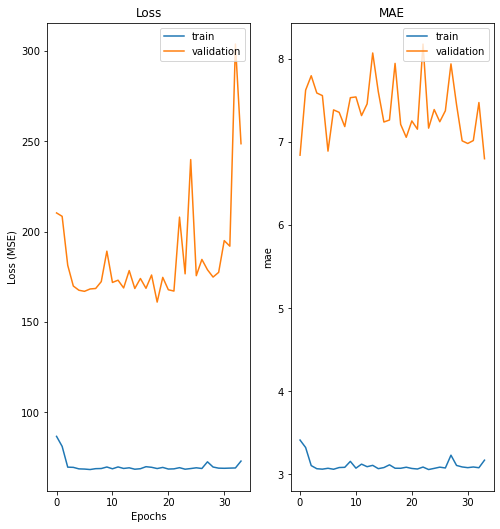

Min training Loss: 68.26331329345703
Min validation Loss:  160.9724884033203

Final training MAE: 3.1707396507263184
Final validation MAE: 6.797566890716553


In [13]:
# Train
#Training with early stopping

t.tic() #Start timer
history = fit_model_es_checkpoint(X_train, y_train, lr, num_epochs, batch_size, model)
t.toc() #Time elapsed since t.tic()

# Visualization
train_val_plot(history)

# Testing the model
As long as two models share the same architecture you can share weights between them. So, when restoring a model from weights-only, create a model with the same architecture as the original model and then set its weights.

In [14]:
# Define the model
model = design_model(n_steps, lr)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, None, 6, 64)      128       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 3, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, None, 192)        0         
 tributed)                                                       
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              131584    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                

In [18]:
folder_models = "Trained_Models"
file_path = str(os.getcwd()) + "/" + folder_models 
file_pre = "/U_Weights_{}*".format(name_prefix)

weights_files = list(glob.glob(file_path + file_pre))
weights_files.sort()

weights_files = [f[len(file_path)+1:] for f in weights_files]

In [19]:
print("Loaded file:", weights_files[0])

# Choosing the best checkpoint (lowest error)
weights_file = folder_models + "/" + weights_files[0] 

# Loading it
model.load_weights(weights_file) 

Loaded file: U_Weights_Uni-Hybrid-CNN-Bi-LSTM_-167.53581--005.hdf5


In [20]:
tmp_df = pd.DataFrame(testing_evaluation(X_test, y_test, model), index=[0])
tmp_df.insert(0, "Model", name_prefix.replace("-", " "), True)
tmp_df

,Model,RMSE,MAE,MAPE,R^2,Max Error
0,Uni Hybrid CNN Bi LSTM,10.018997,6.883792,2.792561e+15,0.551921,394.763083


# Sources
* https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
* https://www.tensorflow.org/tutorials/keras/save_and_load